# Final project: Stock Prediction

Given the recent stock market history, you will predict the return for ticker AAPL for the day ahead.

# Objectives

You will demonstrate your strengths in several areas, especially
- Exploratory Data Analysis
- Feature Engineering
- Creating, testing and evaluating models
- Error analysis
and Prediction **using Neural Networks**.

Your objective will be to predict next period price returns of a stock given its past prices.

**To be precise**
- given recent prices for AAPL you will predict the next *return*
- *return* will be defined precisely below
- you will be evaluated on a holdout data directory
    - it will have 2 years of data
    - you will be required to predict next period returns for the final 200 days
    - when making a prediction for date $t$, where $t$ is in the holdout data range (**beyond** the last training date)
        - you may use *actual* holdout data for dates strictlty prior to date $t$
        - That is: your prediction for date $t$ *does not* need to be dependent on your *prediction* for date $(t-1)$
    

**Predicting forward returns/prices is hard ! If you could do it well: you would be rich**

Given that fact, out of sample performance will **not** be the sole metric for your grade

This project will test your ability to analyze data, create hypotheses, test them, and improve through iteration.

**You will learn a lot, especially from failures**

This project provides a wealth of opportunity for
- Exploratory data analysis
    - This can suggest several different approaches to building one or more models
- Error Analysis
- Creating, and evaluating models iteratively, learning from past failures and successes.

So your performance will be based on your creativity and experimental process, even if the process
does not lead to great out of sample performance

# The data

As explained in the Final Project Overview:
- you will be given a data directory for training
    - supplied as a compressed archive file in the course's Resource tab in NYU Classes
    - unpacking this file will yield directory `./Data/train`

The data directory will contain one file per ticker, with a history going back many years of fields including
- Price: Close, Adj Close, Open, High, Low
- Volume

"return" means the percent change in the **Close** feature
- you can choose to define return based on the **Adj Close** feature
    - but you should explain your choice
    - in the rest of the instructions: the word "Close" will refer to whichever choice you made


You will need to
- decide which files and which fields to use
- prepare the data for training and testing
    - convert from price to return as necessary
    - prepare train and test examples:
    

In [ ]:
import os
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

## Instructions to Ensure Proper File Loading:
1. Please make sure to mount Google Drive in this Colab notebook by running the provided cell below. This will allow access to the dataset stored in your Google Drive.
2. The dataset 'AAPL.csv' should be placed in the following path in your Google Drive: 'My Drive/stock_prediction/Data/train/AAPL.csv'.
3. After mounting, the code will automatically load the dataset from the specified location.
4. If you encounter a FileNotFoundError, please verify that the dataset is correctly placed in the expected directory structure.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/stock_prediction/Data/train/AAPL.csv'
df = pd.read_csv(file_path, index_col='Dt', parse_dates=True)

In [ ]:
df = df.copy()

In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4277 entries, 2000-01-03 to 2016-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  4277 non-null   float64
 1   Close      4277 non-null   float64
 2   Div        4277 non-null   float64
 3   Factor     4277 non-null   float64
 4   High       4277 non-null   float64
 5   Low        4277 non-null   float64
 6   Open       4277 non-null   float64
 7   Volume     4277 non-null   float64
dtypes: float64(8)
memory usage: 300.7 KB


Adj Close    Close  Div  Factor     High      Low      Open  \
Dt                                                                        
2000-01-03     3.4785  111.938  0.0     1.0  112.500  101.688  104.8750   
2000-01-04     3.1852  102.500  0.0     1.0  110.625  101.188  108.2500   
2000-01-05     3.2318  104.000  0.0     1.0  110.563  103.000  103.7500   
2000-01-06     2.9521   95.000  0.0     1.0  107.000   95.000  106.1183   
2000-01-07     3.0920   99.500  0.0     1.0  101.000   95.500   96.5000   

                 Volume  
Dt                       
2000-01-03  133949200.0  
2000-01-04  128094400.0  
2000-01-05  194580400.0  
2000-01-06  191993200.0  
2000-01-07  115183600.0

## Data preparation

- The files contain prices; your goal is to predict a *return* not a price
- Your goal is to predict the **percent change of the Close feature** ("return")
- Your predicted return for day $t$ should be a function of data occuring *before* day $t$

So your first step will be to create a suitable training set.

For example, the following training set is a good starting point:
- each row is an example
- each row will have a column `Dt` indicating time $t$
- each example has at least 20 prior days of data
    - derived from AAPL features occuring *before* time $t$
- the target for the row with time $t$ should be the *return* of AAPL for date $t$
    - i.e., the percent price change of AAPL from time $t-1$ to time $t$



In [ ]:
df.isnull().sum()

Adj Close    0
Close        0
Div          0
Factor       0
High         0
Low          0
Open         0
Volume       0
dtype: int64

## Calculating Returns Using 'Adj Close' Instead Of 'Close':


'Adj Close' is generally a better practice when doing financial modeling, especially for calculating returns over time, as it provides a more accurate picture of the stock's performance considering all events that affect value such as dividends and stock splits.




In [ ]:
df['Return'] = df['Adj Close'].pct_change()
df.dropna(inplace = True)

In [ ]:
df.head()

Adj Close   Close  Div  Factor     High      Low      Open  \
Dt                                                                       
2000-01-04     3.1852  102.50  0.0     1.0  110.625  101.188  108.2500   
2000-01-05     3.2318  104.00  0.0     1.0  110.563  103.000  103.7500   
2000-01-06     2.9521   95.00  0.0     1.0  107.000   95.000  106.1183   
2000-01-07     3.0920   99.50  0.0     1.0  101.000   95.500   96.5000   
2000-01-10     3.0376   97.75  0.0     1.0  102.250   94.750  102.0000   

                 Volume    Return  
Dt                                 
2000-01-04  128094400.0 -0.084318  
2000-01-05  194580400.0  0.014630  
2000-01-06  191993200.0 -0.086546  
2000-01-07  115183600.0  0.047390  
2000-01-10  126266000.0 -0.017594

## Exploratory Data Analysis


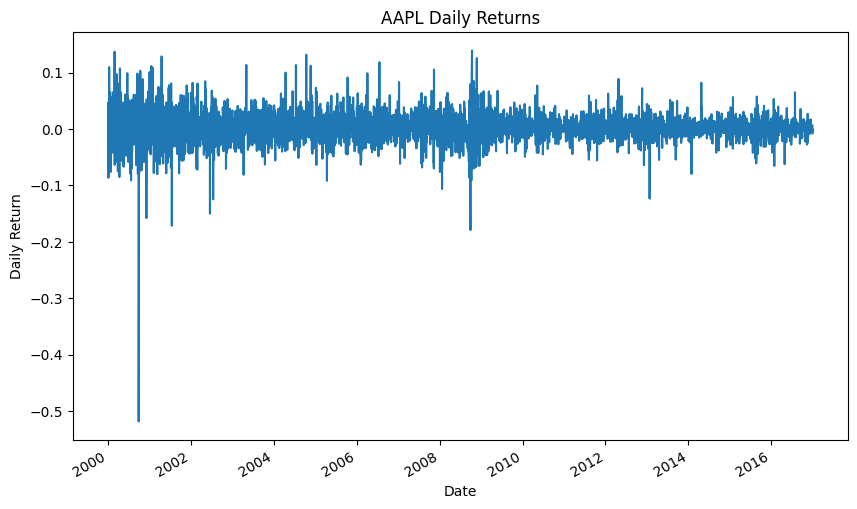

In [ ]:
# 1. Visualize Daily Returns Over Time
plt.figure(figsize=(10, 6))
df['Return'].plot(title='AAPL Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()

This graph above shows the daily returns of AAPL over time. The large negative spike around 2001-2002 represents a period of significant volatility, possibly due to market downturns or specific company events. The overall plot indicates that returns mostly hover around zero, with some periods of higher volatility, especially in the earlier years.

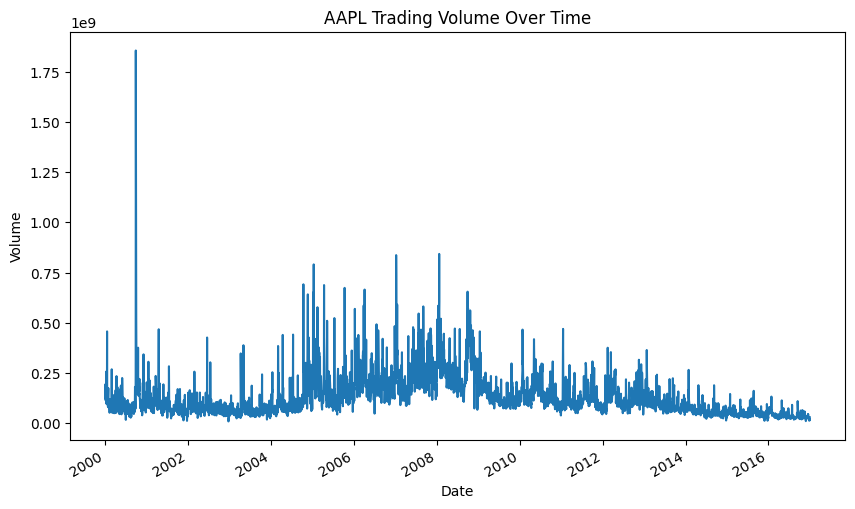

In [ ]:
# 2. Visualize Volume Feature
plt.figure(figsize=(10, 6))
df['Volume'].plot(title='AAPL Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

Analyzing the volume traded can provide insights into how trading activity affects stock returns. Typically, spikes in volume are associated with significant price movements, which may be useful in understanding and predicting future returns.

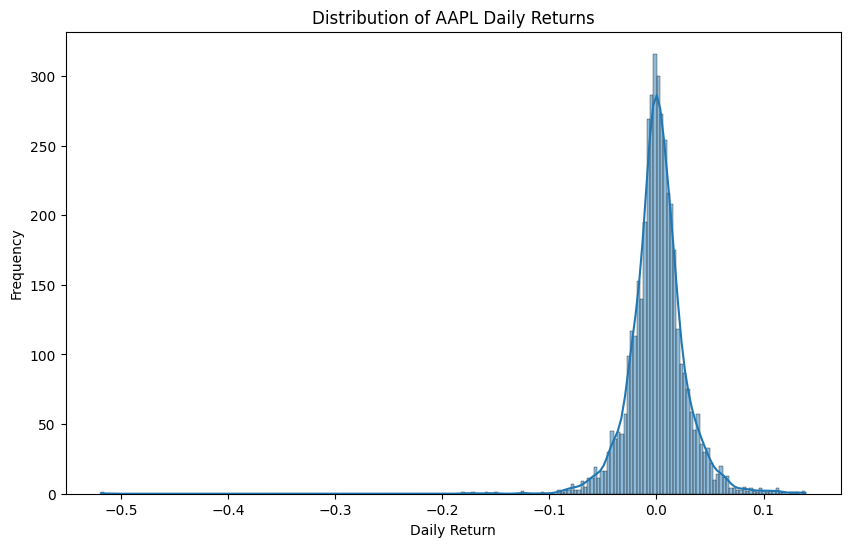

In [ ]:
# 3. Distribution of Returns
plt.figure(figsize=(10, 6))
sns.histplot(df['Return'], kde=True)
plt.title('Distribution of AAPL Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

This histogram shows the distribution of AAPL's daily returns. Most of the returns are concentrated around zero, indicating that the stock typically has small daily movements. There are some outliers on both the negative and positive sides, indicating occasional significant gains or losses. The peak around zero suggests that the majority of the returns are low in magnitude.

## Feature Engineering
Below are some additional features engineered to improve return prediction:


1. **Momentum Indicators**: Measures the rate of change of price movement (e.g., Momentum_5).
2. **MACD (Moving Average Convergence Divergence)**: Captures trend direction and strength.
3. **RSI (Relative Strength Index)**: Indicates overbought or oversold conditions.
4. **SMA (Simple Moving Average)** and **EMA (Exponential Moving Average)**: Track average price trends over different time frames.
5. **Volatility**: Measured via rolling standard deviation.
6. **Bollinger Bands**: Highlights price volatility with upper, lower, and mid-level bands.
7. **Average True Range (ATR)**: Quantifies market volatility by considering the range between high, low, and previous closing prices.

In [ ]:
!pip install pandas-ta

In [ ]:
import pandas_ta as ta

In [ ]:
# 1. Momentum Indicators
df['Momentum_5'] = ta.roc(df['Adj Close'], length=5)

# 2. MACD (Moving Average Convergence Divergence)
df['MACD'], df['Signal_Line'] = ta.macd(df['Adj Close'], fast=12, slow=26, signal=9).iloc[:, 0:2].T.values
df['MACD_Diff'] = df['MACD'] - df['Signal_Line']

# 3. RSI (Relative Strength Index)
df['RSI'] = ta.rsi(df['Adj Close'], length=14)

# 4. SMA (Simple Moving Average)
df['SMA_10'] = ta.sma(df['Adj Close'], length=10)
df['SMA_60'] = ta.sma(df['Adj Close'], length=60)

# EMA (Exponential Moving Average)
df['EMA_10'] = ta.ema(df['Adj Close'], length=10)

# 5. Volatility (Rolling Standard Deviation)
df['Volatility_10'] = df['Adj Close'].rolling(window=10).std()

# 6. Bollinger Bands
bb = ta.bbands(df['Adj Close'], length=20, std=2)
df['Bollinger_Upper'] = bb['BBU_20_2.0']
df['Bollinger_Lower'] = bb['BBL_20_2.0']
df['Bollinger_Mid'] = bb['BBM_20_2.0']
df['Bollinger_Width'] = df['Bollinger_Upper'] - df['Bollinger_Lower']

# 7. ATR (Average True Range)
df['ATR'] = ta.atr(high=df['High'], low=df['Low'], close=df['Adj Close'], length=14)

# Drop rows with NaN values created by feature engineering
df = df.dropna()

In [ ]:
df.columns

Index(['Adj Close', 'Close', 'Div', 'Factor', 'High', 'Low', 'Open', 'Volume',
       'Return', 'Momentum_5', 'MACD', 'Signal_Line', 'MACD_Diff', 'RSI',
       'SMA_10', 'SMA_60', 'EMA_10', 'Volatility_10', 'Bollinger_Upper',
       'Bollinger_Lower', 'Bollinger_Mid', 'Bollinger_Width', 'ATR'],
      dtype='object')

In [ ]:
correlation_matrix = df.corr()

# Display the correlation of features with 'Return'
correlation_with_return = correlation_matrix['Return'].sort_values(ascending=False)
print("Correlation of features with 'Return':")
print(correlation_with_return)

Correlation of features with 'Return':
Return             1.000000
Momentum_5         0.456061
RSI                0.309856
Signal_Line        0.099395
MACD               0.040056
Factor             0.018368
MACD_Diff          0.011835
Close              0.007488
Low                0.002889
High               0.001713
Open              -0.002519
Div               -0.002620
Adj Close         -0.002699
ATR               -0.006091
EMA_10            -0.012232
SMA_10            -0.013153
Bollinger_Lower   -0.013382
Bollinger_Mid     -0.013858
Bollinger_Upper   -0.014276
SMA_60            -0.014550
Volatility_10     -0.016923
Bollinger_Width   -0.019023
Volume            -0.061484
Name: Return, dtype: float64


In [ ]:
# Select features with positive or negative correlation above thresholds
useful_features = correlation_with_return[(correlation_with_return.abs() > 0.1)].index

print("Features with abs correlation > 0.1 with 'Return':")
print(useful_features)

Features with abs correlation > 0.1 with 'Return':
Index(['Return', 'Momentum_5', 'RSI'], dtype='object')


In [ ]:
high_corr_threshold = 0.8

# Find pairs of features with high correlation
high_corr_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs != 1]  # Remove self-correlation

print("Highly correlated feature pairs:")
print(high_corr_pairs[high_corr_pairs > high_corr_threshold])

Highly correlated feature pairs:
SMA_10           EMA_10             0.999963
EMA_10           SMA_10             0.999963
Open             High               0.999919
High             Open               0.999919
                 Close              0.999907
                                      ...   
Bollinger_Width  Adj Close          0.823464
                 Bollinger_Lower    0.804771
Bollinger_Lower  Bollinger_Width    0.804771
Bollinger_Upper  Volatility_10      0.804479
Volatility_10    Bollinger_Upper    0.804479
Length: 82, dtype: float64


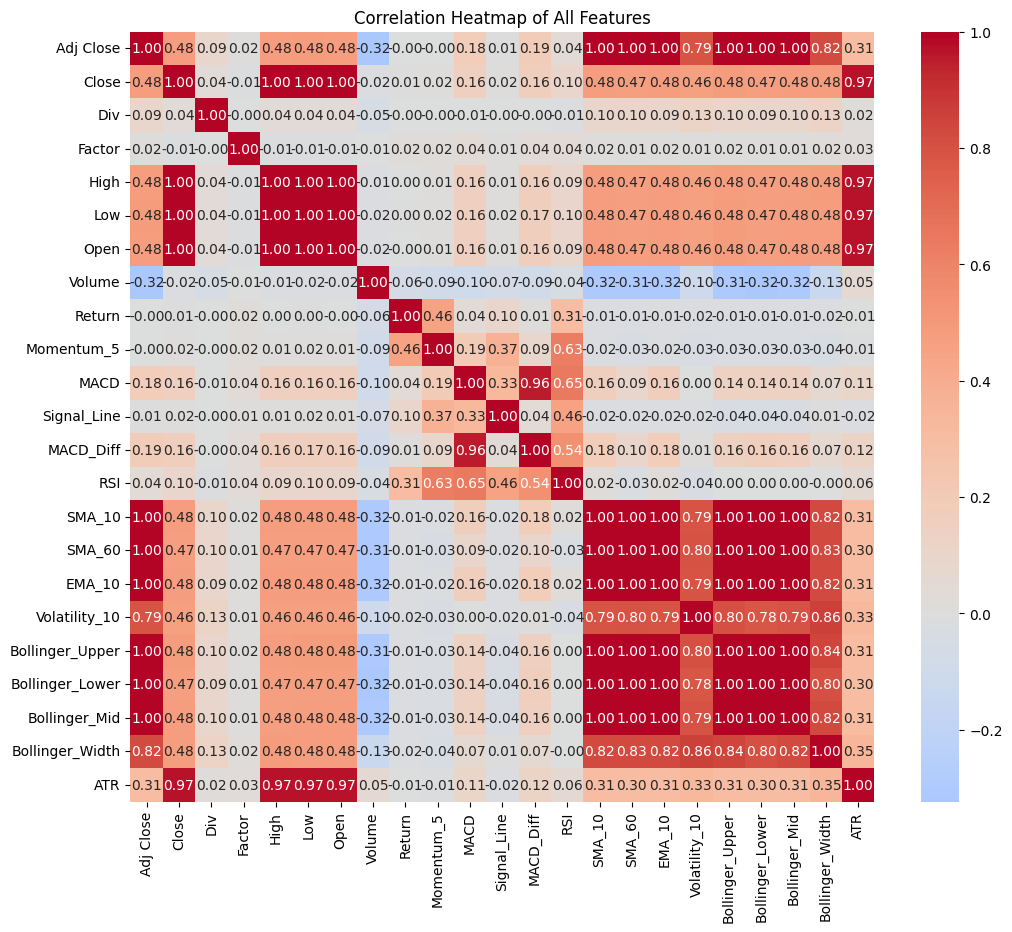

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of All Features')
plt.show()

From the correlation matrix, we can find out that there are lots of highly correlated features. However, only few features 'Momentum_5' and 'RSI'  have over abs 0.1 correlation with returns. There are several reasons. Stock returns are notoriously difficult to predict due to their high noise and randomness, resulting in weak linear relationships between features and the target. Additionally, many financial indicators may have non-linear or lagged relationships with returns that cannot be captured by simple correlations.
## How to Address This Issue

1. **Include All Features**: Even features with low linear correlation may be useful in more complex, non-linear models.
2. **Feature Engineering**: Create lagged features, interaction terms (e.g., Momentum * RSI), or apply transformations like logarithms to enhance signal strength.
3. **Lower Correlation Threshold**: Include features with \( |r| > 0.05 \) to broaden the feature set.
4. **Add More Features**: Include external factors like volume-based metrics for additional predictive power.

In [ ]:
# 8. Additional Features
df['Momentum_10'] = ta.roc(df['Adj Close'], length=10)  # Additional momentum indicator

df['SMA_50'] = ta.sma(df['Adj Close'], length=50)

df['Volatility_Ratio'] = df['Volatility_10'] / df['Adj Close']

# Williams %R
df['Williams_%R'] = ta.willr(high=df['High'], low=df['Low'], close=df['Adj Close'], length=14)

# Stochastic Oscillator
stoch = ta.stoch(high=df['High'], low=df['Low'], close=df['Adj Close'], k=14, d=3)
df['Stoch_%K'] = stoch['STOCHk_14_3_3']
df['Stoch_%D'] = stoch['STOCHd_14_3_3']

df = df.dropna()

In [ ]:
df.columns

Index(['Adj Close', 'Close', 'Div', 'Factor', 'High', 'Low', 'Open', 'Volume',
       'Return', 'Momentum_5', 'MACD', 'Signal_Line', 'MACD_Diff', 'RSI',
       'SMA_10', 'SMA_60', 'EMA_10', 'Volatility_10', 'Bollinger_Upper',
       'Bollinger_Lower', 'Bollinger_Mid', 'Bollinger_Width', 'ATR',
       'Momentum_10', 'SMA_50', 'Volatility_Ratio', 'Williams_%R', 'Stoch_%K',
       'Stoch_%D'],
      dtype='object')

In [ ]:
# Select features with positive or negative correlation above thresholds
useful_features = correlation_with_return[(correlation_with_return.abs() > 0.05)].index

print("Features with abs correlation > 0.05 with 'Return':")
print(useful_features)

Features with abs correlation > 0.05 with 'Return':
Index(['Return', 'Momentum_5', 'RSI', 'Signal_Line', 'Volume'], dtype='object')


I will include all features first later on in my first simple neural network model (LSTM). In my revised LSTM model, I will use correlation matrix and feature importance later on to deal with multicollinearity issue between features and select useful features to predict returns.
## Why do I choose LSTM?
LSTM (Long Short-Term Memory) models are well-suited for time-series forecasting tasks because they effectively capture long-term dependencies and sequential patterns in data. Unlike traditional RNN models, LSTMs are designed to handle the vanishing gradient problem, allowing them to learn and retain information over extended time steps. By leveraging features such as past returns, technical indicators, and volatility measures, the LSTM model can predict stock returns by modeling both short-term fluctuations and long-term trends, making it a robust choice for financial forecasting.

## Fit a Baseline Model

I used a Linear Regression model as the baseline because the goal is to predict a continuous value, specifically the return of AAPL stock, which makes regression a natural choice. Linear Regression also provides a straightforward benchmark for assessing the added value of more complex models.

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
# Create lagged features (20 prior days of data) for the model
for lag in range(1, 21):
    df.loc[:, f'Return_Lag_{lag}'] = df['Return'].shift(lag)

<ipython-input-111-b45ad2983926>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f'Return_Lag_{lag}'] = df['Return'].shift(lag)
<ipython-input-111-b45ad2983926>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f'Return_Lag_{lag}'] = df['Return'].shift(lag)
<ipython-input-111-b45ad2983926>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [ ]:
df.dropna(inplace = True)

<ipython-input-112-d1ada024d2eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


In [ ]:
train_data = df[df.index.year <= 2014]
test_data = df[df.index.year > 2014]

In [ ]:
X_train = train_data[[f'Return_Lag_{lag}' for lag in range(1, 21)]]
y_train = train_data['Return']
X_test = test_data[[f'Return_Lag_{lag}' for lag in range(1, 21)]]
y_test = test_data['Return']

In [ ]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [ ]:
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

In [ ]:
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Training MSE: {mse_train:.4f}, MAE: {mae_train:.4f}, R^2: {r2_train:.4f}")
print(f"Testing MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, R^2: {r2_test:.4f}")

Training MSE: 0.0007, MAE: 0.0183, R^2: 0.0129
Testing MSE: 0.0003, MAE: 0.0116, R^2: -0.0223


I chose these evaluation metrics to assess the performance of my model because they each provide different insights:

1. **Mean Squared Error (MSE)**: MSE measures the average squared difference between the actual and predicted values. It is useful to identify how much the predictions deviate from the actual returns, with larger errors being penalized more due to squaring. This helps in understanding the overall model accuracy and sensitivity to larger errors.

2. **Mean Absolute Error (MAE)**: MAE measures the average absolute difference between actual and predicted values. Unlike MSE, it gives equal weight to all errors, which provides a more interpretable view of the model's accuracy. It is useful for understanding the average magnitude of errors in the same units as the target.

3. **R² Score (R-squared)**: The R² score indicates how well the model explains the variance in the target variable. A higher R² value suggests that the model captures more of the variability in the data, which is especially important for regression models where the goal is to predict returns effectively.

Using a combination of these metrics allows for a more comprehensive evaluation of model performance by capturing different aspects of accuracy, error magnitude, and model explanatory power.

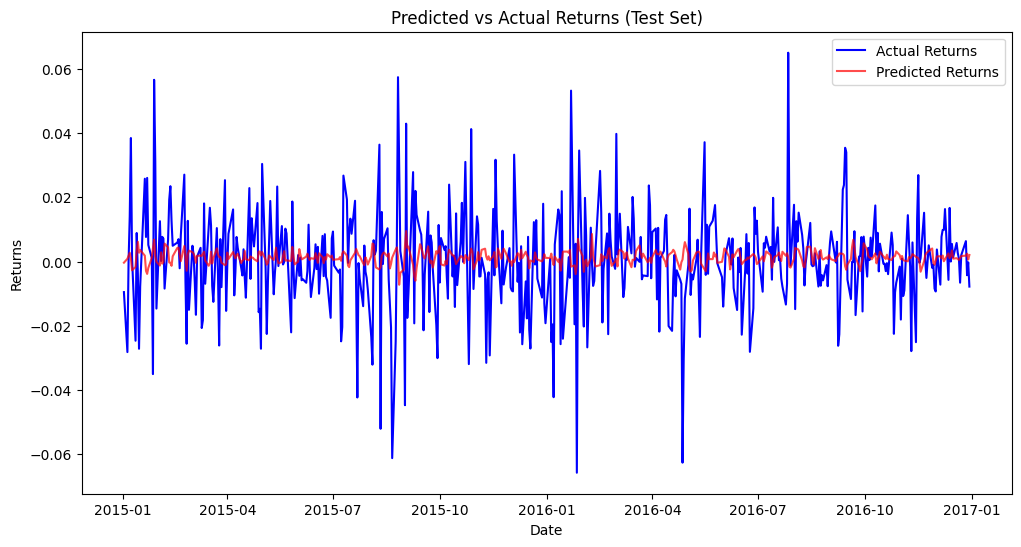

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label="Actual Returns", color="blue")
plt.plot(test_data.index, y_pred_test, label="Predicted Returns", color="red", alpha=0.7)
plt.title("Predicted vs Actual Returns (Test Set)")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.show()

## Why is R^2 Negative?

A negative \( R^2 \) score indicates that the model performs worse than a simple mean predictor, meaning it fails to explain the variance in returns effectively. This occurs because the residual sum of squares exceeds the total variance. In this case, the linear regression model struggles to capture the complex, non-linear relationships inherent in stock returns, which are highly volatile and largely influenced by noise. Additionally, using only lagged returns as features may not provide sufficient predictive power. This highlights the limitations of the baseline model and suggests a need for more robust feature engineering or advanced modeling techniques.



## LSTM Model for Predicting Stock Returns Using Only AAPL Data

In this step, I will improve upon the baseline linear regression model by building an LSTM-based neural network to capture temporal dependencies in the data. The model will utilize 20 lagged returns and engineered features such as Momentum, RSI, MACD, Bollinger Bands, and ATR. A time-based train-test split will be applied, where all data up to 2015 will serve as the training set, and data from 2016 onward will be used for testing. Additionally, a sequence length of 90 days will be used to create time-series sequences for the LSTM model. During training, I will implement cross-validation to ensure robust validation of the model. The LSTM model will be designed with two LSTM layers, dropout regularization, and a dense regression output layer. Finally, I will evaluate the model using metrics like MSE, MAE, \( R^2 \), and directional accuracy, and visualize predicted vs actual returns on the test set.

In [ ]:
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# os.environ['PYTHONHASHSEED'] = '42'
# random.seed(42)
# np.random.seed(42)
# tf.random.set_seed(42)

The first simple LSTM will use all features suggested above.

In [ ]:
for lag in range(1, 21):
    df[f'Return_Lag_{lag}'] = df['Return'].shift(lag)

df = df.dropna()

feature_columns = [f'Return_Lag_{i}' for i in range(1, 21)] + [
    'Momentum_5', 'RSI', 'Signal_Line', 'MACD', 'Bollinger_Width',
    'ATR', 'Stoch_%K', 'Stoch_%D', 'Volume', 'SMA_10', 'SMA_60', 'EMA_10', 'Volatility_10',
    'Momentum_10', 'Williams_%R', 'MACD_Diff', 'SMA_50', 'Volatility_Ratio'
]

train_data = df[df.index.year <= 2014]
test_data = df[df.index.year > 2014]

X_train = train_data[feature_columns]
y_train = train_data['Return'].values.reshape(-1, 1)
X_test = test_data[feature_columns]
y_test = test_data['Return'].values.reshape(-1, 1)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit only on training data
X_test_scaled = scaler.transform(X_test)

print(f"Train data shape: {X_train.shape}, Test data shape: {X_test.shape}")

Train data shape: (3624, 38), Test data shape: (504, 38)


In [ ]:
def create_sequences(X, y=None, seq_length=90, return_y=True):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        if y is not None and return_y:
            y_seq.append(y[i+seq_length])

    X_seq = np.array(X_seq)

    if y is not None and return_y:
        y_seq = np.array(y_seq)
    else:
        y_seq = None

    return X_seq, y_seq

seq_length = 90
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, seq_length)
print(f"Train sequence shape: {X_train_seq.shape}, Test sequence shape: {X_test_seq.shape}")

Train sequence shape: (3534, 90, 38), Test sequence shape: (414, 90, 38)


In [ ]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, activation='tanh', input_shape=input_shape),
        Dropout(0.2),
        LSTM(64, return_sequences=False, activation='tanh'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

In [ ]:
split_index = int(0.8 * len(X_train_seq))
X_train_fold, X_val_fold = X_train_seq[:split_index], X_train_seq[split_index:]
y_train_fold, y_val_fold = y_train_seq[:split_index], y_train_seq[split_index:]

In [ ]:
basic_model = build_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]))
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = basic_model.fit(
    X_train_fold, y_train_fold,
    validation_data=(X_val_fold, y_val_fold),
    epochs=50,
    batch_size=32,
    verbose=1,
    shuffle=False,
    # callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0060 - mae: 0.0570 - val_loss: 0.0019 - val_mae: 0.0315
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0018 - mae: 0.0328 - val_loss: 9.4402e-04 - val_mae: 0.0220
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - mae: 0.0267 - val_loss: 4.3919e-04 - val_mae: 0.0149
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 5.2878e-04 - val_mae: 0.0160
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - mae: 0.0237 - val_loss: 4.4391e-04 - val_mae: 0.0148
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.8961e-04 - mae: 0.0231 - val_loss: 3.6307e-04 - val_mae: 0.0135
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - mae: 0.0234 - val_loss: 3.6063e-04 - val_mae: 0.0134
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - mae: 0.0233 - val_loss: 3.4588e-04 - val_mae: 0.0130
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━

In [ ]:
y_pred_test = basic_model.predict(X_test_seq)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [ ]:
def error_analysis(y_true, y_pred):
    direction_accuracy = np.mean(np.sign(y_pred.flatten()) == np.sign(y_true.flatten())) * 100
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Test MSE: {mse:.4f}, Test MAE: {mae:.4f}, Test R^2: {r2:.4f}")
    print(f"Directional Accuracy: {direction_accuracy:.2f}%")
    return mse, mae, r2, direction_accuracy

In [ ]:
# Function to Plot Training and Validation Loss and MAE
def plot_training_history(history):
    plt.figure(figsize=(14, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE', color='blue')
    plt.plot(history.history['val_mae'], label='Validation MAE', color='orange')
    plt.title('MAE During Training')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_predictions(y_test_seq, y_pred_test):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_seq, label='Actual Returns', color='blue', alpha=0.8)
    plt.plot(y_pred_test, label='Predicted Returns', color='red', alpha=0.8)
    plt.title('LSTM Model: Predicted vs Actual Returns (Test Set)')
    plt.xlabel('Time Steps')
    plt.ylabel('Returns')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
error_analysis(y_test_seq, y_pred_test)

Test MSE: 0.0003, Test MAE: 0.0117, Test R^2: -0.0593
Directional Accuracy: 48.07%


(0.00026074327347136444,
 0.011727342907449301,
 -0.05926824453194812,
 48.06763285024155)

I add the directional accuracy as a evaluation metric. Directional accuracy measures the percentage of times the model correctly predicts the direction of change (up or down) in the target variable, regardless of the magnitude. It is calculated by comparing the sign of the predicted values with the sign of the actual values. This metric is particularly useful in financial applications, such as stock returns, where predicting the correct direction can be more critical than predicting the exact value.

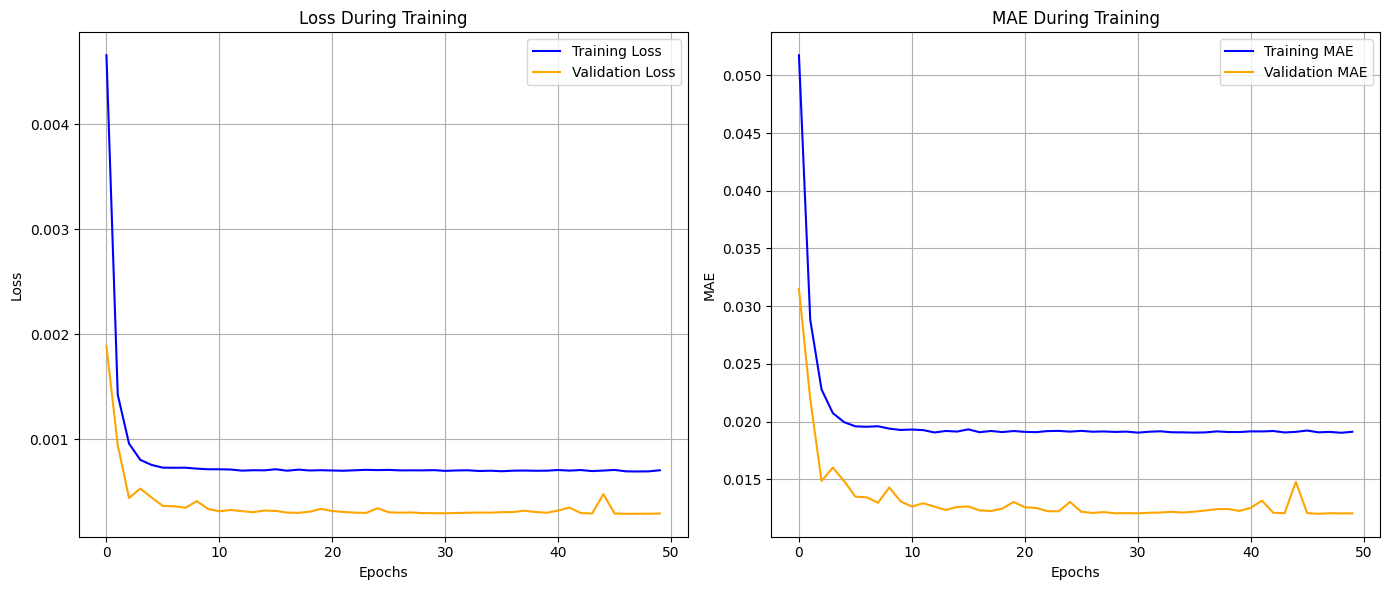

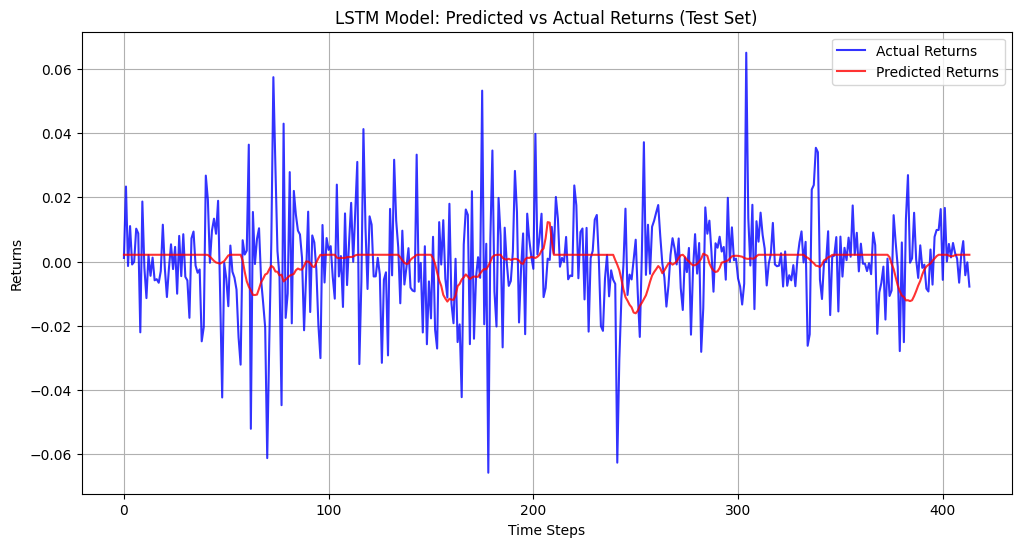

In [ ]:
plot_training_history(history)
plot_predictions(y_test_seq, y_pred_test)

## Error Analysis

1. **Error Metrics**:  
   - The Mean Squared Error (MSE), Mean Absolute Error (MAE), and R² values are calculated to evaluate the overall performance of the model.  
   - These metrics provide insights into the average magnitude of errors and the goodness-of-fit of the predictions.

2. **Error Distribution**:  
   - A histogram displays the distribution of prediction errors.  
   - This helps identify whether errors are centered around zero or skewed in any particular direction.

3. **Actual vs Predicted Plot**:  
   - A scatter plot is used to visualize the relationship between actual returns and predicted returns.  
   - Ideally, the points should align closely to the diagonal line, which represents perfect predictions.

4. **Residuals Over Time**:  
   - Residuals (errors) are plotted over time to detect systematic biases or time-dependent issues in predictions.  
   - A consistent pattern in residuals might indicate areas where the model is underperforming.

5. **Directional Accuracy**:  
   - Measures the percentage of times the model correctly predicts the direction (positive or negative) of returns.  
   - This metric is particularly important for financial time series, where predicting the direction of movement is often more critical than the magnitude.

6. **Error Segmentation**:  
   - Cases with the largest errors (e.g., the top 5% by error magnitude) are identified and analyzed.  
   - This provides insights into specific scenarios where the model struggles and can guide targeted improvements in features or model architecture.

Since 1 and 5 I have done in the previous error_analysis function, I will not repeat in the later code.

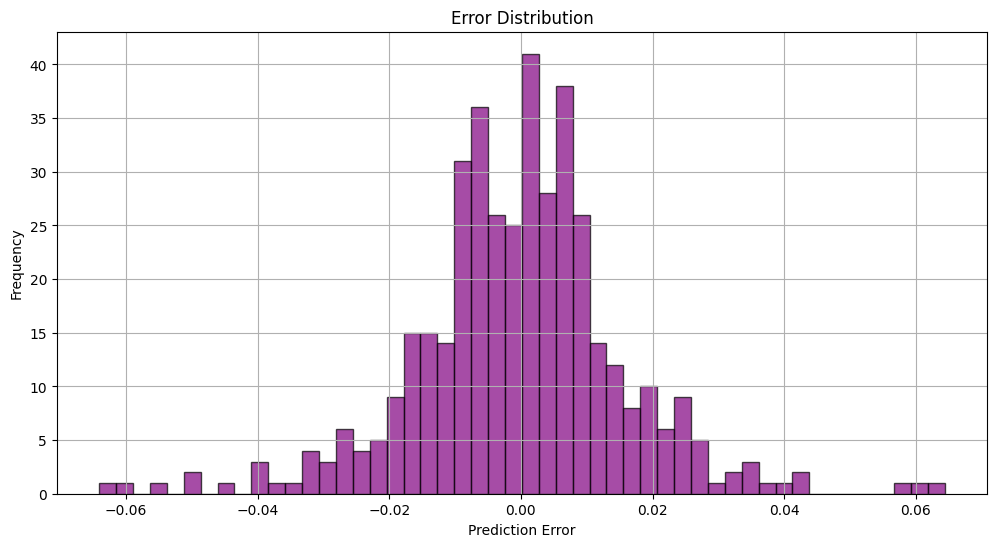

In [ ]:
errors = y_pred_test.flatten() - y_test_seq.flatten()
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

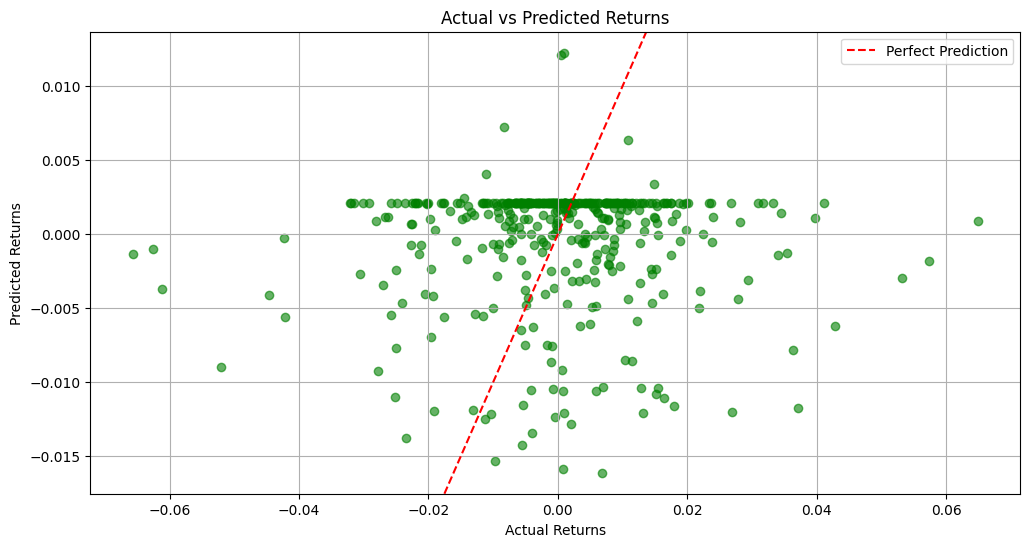

In [ ]:
# Plot actual vs predicted returns
plt.figure(figsize=(12, 6))
plt.scatter(y_test_seq, y_pred_test, alpha=0.6, color='green')
plt.title('Actual vs Predicted Returns')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.grid(True)
plt.show()

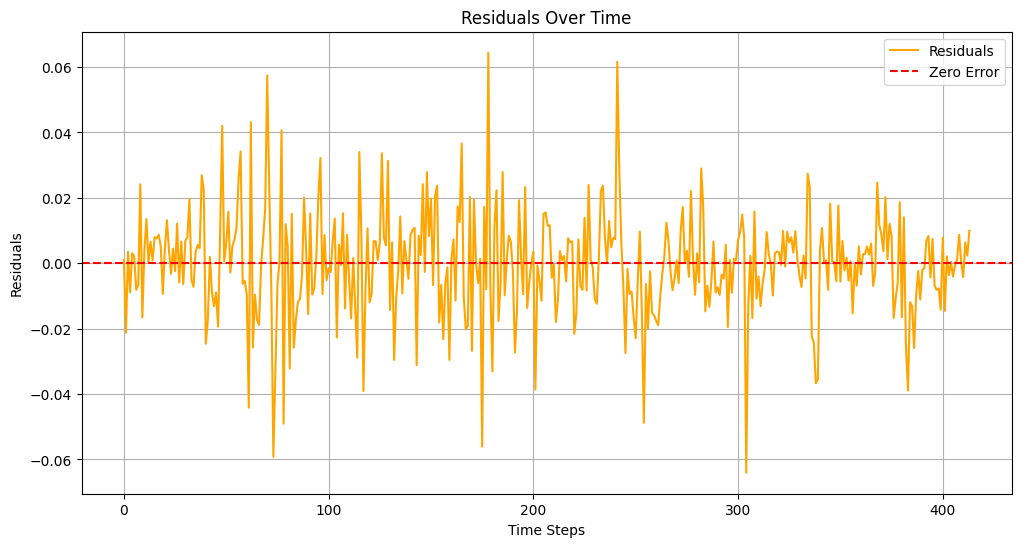

In [ ]:
# Residuals over time
plt.figure(figsize=(12, 6))
plt.plot(errors, color='orange', label='Residuals')
plt.title('Residuals Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Error segmentation: Identify large errors
threshold = np.percentile(np.abs(errors), 95)  # Top 5% errors
large_error_indices = np.where(np.abs(errors) > threshold)[0]
large_errors = errors[large_error_indices]
print(f"Number of large errors (above 95th percentile): {len(large_errors)}")

Number of large errors (above 95th percentile): 21


In [ ]:
# Analyze large error cases
large_error_data = pd.DataFrame({
    'Actual Return': y_test_seq.flatten()[large_error_indices],
    'Predicted Return': y_pred_test.flatten()[large_error_indices],
    'Error': large_errors
})
print("Top 5 largest error cases:")
print(large_error_data.nlargest(5, 'Error'))

Top 5 largest error cases:
    Actual Return  Predicted Return     Error
13      -0.065707         -0.001341  0.064365
15      -0.062578         -0.000999  0.061579
4       -0.061163         -0.003715  0.057448
3       -0.052038         -0.008934  0.043104
0       -0.042294         -0.000263  0.042031


The error analysis highlights several areas where the model's performance can be improved. The calculated MSE and MAE indicate moderate prediction errors. The significantly negative R² score demonstrates that the model struggles to explain the variance in returns effectively. Examining the error distribution reveals a non-uniform spread, with certain error ranges being more frequent, pointing to potential biases in the predictions. The actual vs. predicted plot shows deviations from the ideal prediction line, particularly for extreme values, underscoring the model's difficulty in capturing large return fluctuations. Residuals plotted over time exhibit temporal patterns, suggesting underfitting or the need for better temporal feature modeling. The directional accuracy of 43.21% indicates that the model performs slightly better than random guessing when predicting return directions, signaling an opportunity for significant improvement. Finally, the segmentation of the largest errors (top 5%) identifies specific instances where predictions deviate substantially from actual values, indicating that these cases may require additional focus during feature engineering or model refinement.

## The Improved LSTM Model Using Only AAPL Data

Instead of using all features like the simple model, I want to make sure I only incorporate useful features to predict returns and solve the issue of multicollinearity through correlation matrix and the feature importance model.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import BatchNormalization

In [ ]:
feature_columns = [f'Return_Lag_{i}' for i in range(1, 21)] + [
    'Momentum_5', 'RSI', 'Signal_Line', 'MACD', 'Bollinger_Width',
    'ATR', 'Stoch_%K', 'Stoch_%D', 'Volume', 'SMA_10', 'SMA_60', 'EMA_10', 'Volatility_10',
    'Momentum_10', 'Williams_%R', 'MACD_Diff', 'SMA_50', 'Volatility_Ratio'
]

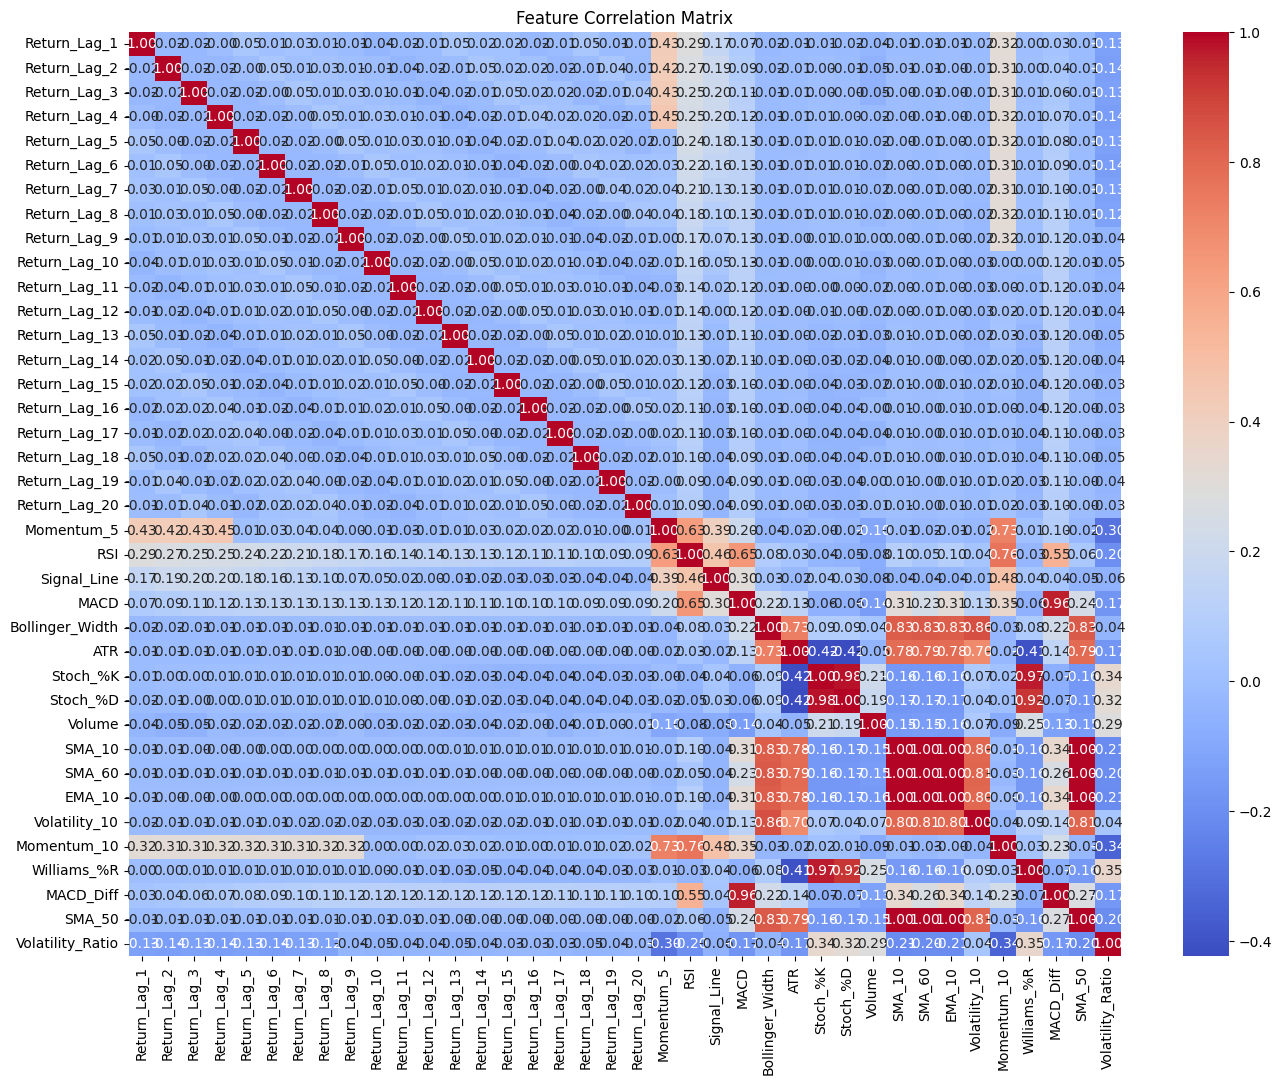

In [ ]:
plt.figure(figsize=(16, 12))
sns.heatmap(train_data[feature_columns].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


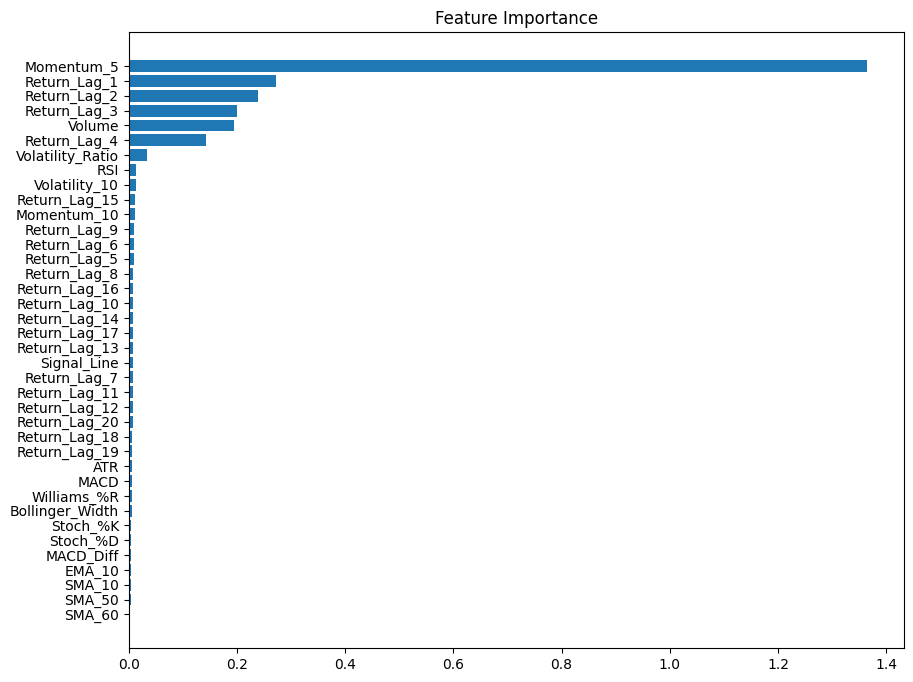

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# Train a Random Forest for feature importance
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Permutation Importance
perm_importance = permutation_importance(rf, X_train, y_train, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_columns[i] for i in sorted_idx])
plt.title("Feature Importance")
plt.show()

In [ ]:
# Step 1: Calculate the correlation matrix
correlation_matrix = pd.DataFrame(X_train, columns=feature_columns).corr()

# Step 2: Set a correlation threshold
threshold = 0.8

# Step 3: Find pairs of features with high correlation
high_corr_pairs = np.where(np.abs(correlation_matrix) > threshold)
high_corr_pairs = [(correlation_matrix.index[i], correlation_matrix.columns[j])
                   for i, j in zip(*high_corr_pairs) if i != j and i < j]

# Step 4: Identify features to drop
features_to_drop = set()
for feature_1, feature_2 in high_corr_pairs:
    features_to_drop.add(feature_2)  # Arbitrarily choose one feature to drop

# Step 5: Drop correlated features
X_train_filtered = pd.DataFrame(X_train, columns=feature_columns).drop(columns=features_to_drop)

# Updated feature columns
filtered_feature_columns = X_train_filtered.columns.tolist()

# Print the features dropped
print(f"Dropped features: {features_to_drop}")
print(f"Remaining features: {filtered_feature_columns}")


Dropped features: {'MACD_Diff', 'EMA_10', 'SMA_10', 'Volatility_10', 'SMA_50', 'Stoch_%D', 'Williams_%R', 'SMA_60'}
Remaining features: ['Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3', 'Return_Lag_4', 'Return_Lag_5', 'Return_Lag_6', 'Return_Lag_7', 'Return_Lag_8', 'Return_Lag_9', 'Return_Lag_10', 'Return_Lag_11', 'Return_Lag_12', 'Return_Lag_13', 'Return_Lag_14', 'Return_Lag_15', 'Return_Lag_16', 'Return_Lag_17', 'Return_Lag_18', 'Return_Lag_19', 'Return_Lag_20', 'Momentum_5', 'RSI', 'Signal_Line', 'MACD', 'Bollinger_Width', 'ATR', 'Stoch_%K', 'Volume', 'Momentum_10', 'Volatility_Ratio']


In [ ]:
# Feature columns updated
feature_columns = [
     'Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3', 'Return_Lag_4',
     'Return_Lag_5', 'Return_Lag_6', 'Return_Lag_7', 'Return_Lag_8',
     'Return_Lag_9', 'Return_Lag_10', 'Return_Lag_11', 'Return_Lag_12',
     'Return_Lag_13', 'Return_Lag_14', 'Return_Lag_15', 'Return_Lag_16',
     'Return_Lag_17', 'Return_Lag_18', 'Return_Lag_19', 'Return_Lag_20',
     'Momentum_5', 'RSI', 'Signal_Line', 'MACD', 'Bollinger_Width', 'ATR',
     'Stoch_%K', 'Volume', 'Momentum_10', 'Volatility_Ratio'
]

X_train = train_data[feature_columns]
y_train = train_data['Return'].values.reshape(-1, 1)
X_test = test_data[feature_columns]
y_test = test_data['Return'].values.reshape(-1, 1)

print(f"Train data shape: {X_train.shape}, Test data shape: {X_test.shape}")

Train data shape: (3624, 30), Test data shape: (504, 30)


In [ ]:
# Scale features
scaler_X = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale target
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [ ]:
# Adjust sequence length
seq_length = 120
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)

print(f"Train sequence shape: {X_train_seq.shape}, Test sequence shape: {X_test_seq.shape}")

Train sequence shape: (3504, 120, 30), Test sequence shape: (384, 120, 30)


In [ ]:
# Revised LSTM model
def build_optimized_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(256, return_sequences=True, activation='tanh'), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.1),
        Bidirectional(LSTM(128, return_sequences=True, activation='tanh')),
        BatchNormalization(),
        Dropout(0.1),
        LSTM(64, return_sequences=False, activation='tanh'),
        BatchNormalization(),
        Dropout(0.1),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.05),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    return model

In [ ]:
# Train-validation split
split_index = int(0.8 * len(X_train_seq))
X_train_fold, X_val_fold = X_train_seq[:split_index], X_train_seq[split_index:]
y_train_fold, y_val_fold = y_train_seq[:split_index], y_train_seq[split_index:]

In [ ]:
# Train the model
optimized_model = build_optimized_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]))

# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-5)

history = optimized_model.fit(
    X_train_fold, y_train_fold,
    validation_data=(X_val_fold, y_val_fold),
    epochs=100,
    batch_size=32,
    verbose=1,
    shuffle=False,
    # callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 1.5570 - mae: 0.9975 - val_loss: 0.3893 - val_mae: 0.5890
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.9331 - mae: 0.7708 - val_loss: 0.5154 - val_mae: 0.6415
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.7195 - mae: 0.6753 - val_loss: 0.4176 - val_mae: 0.5434
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.5315 - mae: 0.5800 - val_loss: 0.4225 - val_mae: 0.5307
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.4779 - mae: 0.5511 - val_loss: 0.4369 - val_mae: 0.5409
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.4042 - mae: 0.5057 - val_loss: 0.4633 - val_mae: 0.5557
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.3404 - mae: 0.4675 - val_loss: 0.4020 - val_mae: 0.5034
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.3105 - mae: 0.4427 - val_loss: 0.3215 - val_mae: 0.4520
Epoch 9/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - lo

In [ ]:
# Evaluate model
y_pred_test_scaled = optimized_model.predict(X_test_seq)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_original = scaler_y.inverse_transform(y_test_seq)
error_analysis(y_test_original.flatten(), y_pred_test.flatten())

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Test MSE: 0.0007, Test MAE: 0.0203, Test R^2: -1.6237
Directional Accuracy: 48.70%


(0.0006789727057173946,
 0.02029202167336153,
 -1.6237236952924312,
 48.69791666666667)

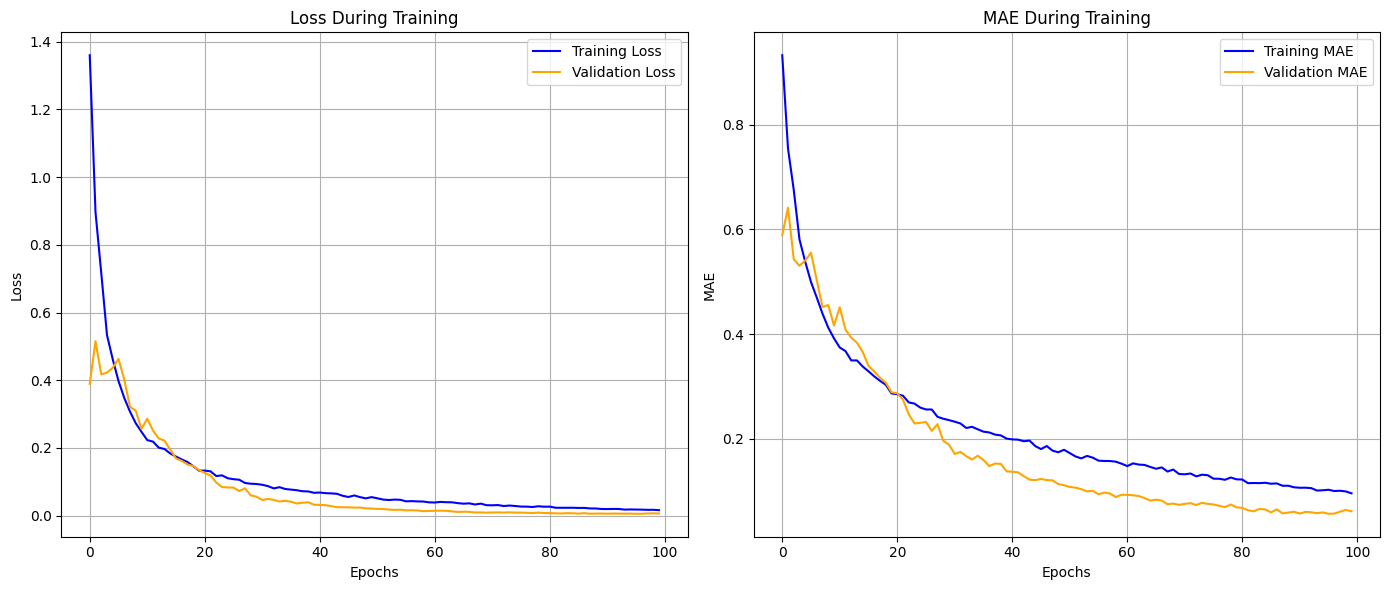

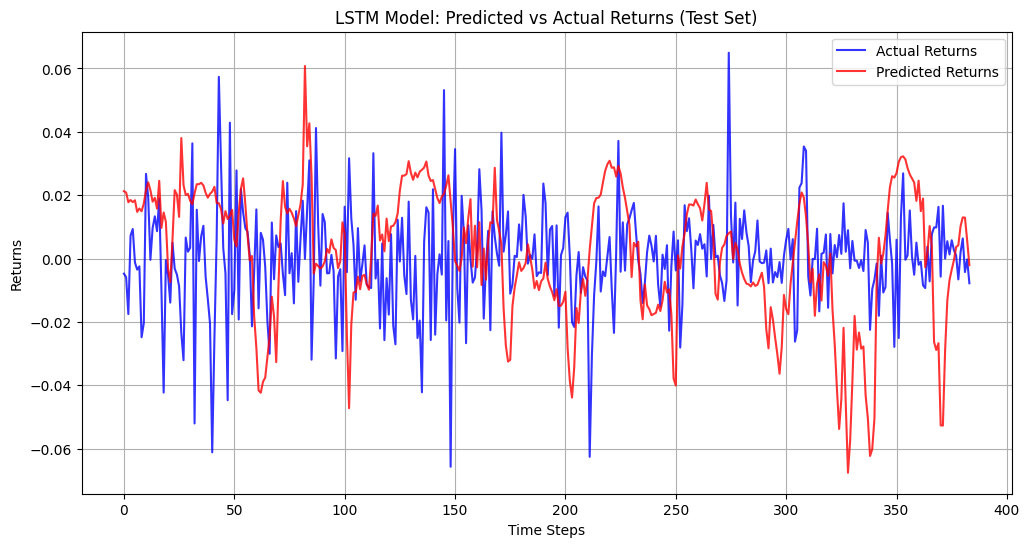

In [ ]:
plot_training_history(history)
plot_predictions(y_test_original.flatten(), y_pred_test.flatten())

In this improved model, several enhancements were made compared to the initial simple LSTM model to optimize performance and accuracy. First, feature selection was rigorously performed using a combination of feature importance rankings and a correlation matrix to ensure only the most relevant and uncorrelated features were included, which helps reduce noise and overfitting. Additionally, the LSTM architecture was enhanced by incorporating Bidirectional LSTM layers to capture both forward and backward temporal dependencies, and Batch Normalization layers were added to stabilize training and improve convergence speed. Dropout rates were carefully adjusted to prevent over-regularization while still mitigating overfitting risks. The sequence length was increased to 120 time steps to capture longer-term dependencies in the data, reflecting the temporal nature of stock returns. Finally, hyperparameters such as learning rate and early stopping patience were fine-tuned for better optimization, and MinMax scaling was applied to target values to ensure compatibility with the LSTM’s output range. These combined improvements allow the model to better generalize to unseen data and provide more robust predictions.


# More Complex Models Incorporate Other Similiar Companies and Macro Data

1. Load all stocks into a dictionary

In [ ]:
import glob

In [ ]:
data_dir = '/content/drive/MyDrive/stock_prediction/Data/train/'

def load_stocks_as_dict(data_dir):
    file_paths = glob.glob(data_dir + '*.csv')
    stock_data = {}

    for file_path in file_paths:
        stock_name = file_path.split('/')[-1].split('.')[0].upper()
        df_stock = pd.read_csv(file_path, index_col='Dt', parse_dates=['Dt'])
        stock_data[stock_name] = df_stock

    return stock_data

In [ ]:
stock_data_dict = load_stocks_as_dict(data_dir)

In [ ]:
print(stock_data_dict['AAPL'].head())

            Adj Close    Close  Div  Factor     High      Low      Open  \
Dt                                                                        
2000-01-03     3.4785  111.938  0.0     1.0  112.500  101.688  104.8750   
2000-01-04     3.1852  102.500  0.0     1.0  110.625  101.188  108.2500   
2000-01-05     3.2318  104.000  0.0     1.0  110.563  103.000  103.7500   
2000-01-06     2.9521   95.000  0.0     1.0  107.000   95.000  106.1183   
2000-01-07     3.0920   99.500  0.0     1.0  101.000   95.500   96.5000   

                 Volume  
Dt                       
2000-01-03  133949200.0  
2000-01-04  128094400.0  
2000-01-05  194580400.0  
2000-01-06  191993200.0  
2000-01-07  115183600.0  


2. Select useful stocks to predict aapl returns.

In [ ]:
aapl_returns = df['Return']
correlations = {}
missing_threshold = 0.1

for stock, stock_data in stock_data_dict.items():
    stock_data = stock_data.reindex(df.index)
    stock_data['Return'] = stock_data['Adj Close'].pct_change()
    missing_fraction = stock_data['Return'].isna().mean()

    if missing_fraction < missing_threshold:
        stock_data['Return'] = stock_data['Return'].interpolate(method='linear')
        correlations[stock] = stock_data['Return'].corr(aapl_returns)
        stock_data_dict[stock] = stock_data

sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
threshold = 0.4
selected_stocks = [stock for stock, corr in sorted_correlations if corr >= threshold]

print("Selected Useful Stocks:")
print(selected_stocks)

Selected Useful Stocks:
['AAPL', 'XLK', 'SPY', 'INTC', 'XLI', 'CSCO', 'XLY', 'IBM', 'MSFT', 'NVDA']


In [ ]:
## The very first code I used to pick my stocks
## Leading to large data points lost

# aapl_returns = df['Return']

# # Compute correlations with AAPL's returns for each stock in the dictionary
# correlations = {}
# for stock, stock_data in stock_data_dict.items():
#     stock_data['Return'] = stock_data['Adj Close'].pct_change()
#     correlations[stock] = stock_data['Return'].corr(aapl_returns)

# # Sort stocks by correlation and filter by a threshold
# sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
# threshold = 0.4
# selected_stocks = [stock for stock, corr in sorted_correlations if corr >= threshold]

# print("Selected Useful Stocks:")
# print(selected_stocks)

3. Merge prvious df with the new data

In [ ]:
selected_stocks = ['XLK', 'SPY', 'INTC', 'XLI', 'CSCO', 'XLY', 'IBM', 'MSFT', 'NVDA']
merged_df = df.copy()

for stock in selected_stocks:
    merged_df[f'{stock}_Return'] = stock_data_dict[stock]['Return']

merged_df = merged_df.dropna()
print(merged_df.head())

            Adj Close   Close  Div  Factor    High     Low    Open  \
Dt                                                                   
2000-08-07     2.9793  47.938  0.0     1.0  49.063  47.188  47.875   
2000-08-08     2.9055  46.750  0.0     1.0  48.000  46.313  47.938   
2000-08-09     2.9521  47.500  0.0     1.0  48.438  47.250  48.125   
2000-08-10     2.9560  47.563  0.0     1.0  48.438  47.375  48.000   
2000-08-11     2.9638  47.688  0.0     1.0  48.000  45.563  46.844   

                Volume    Return  Momentum_5  ...  Return_Lag_20  XLK_Return  \
Dt                                            ...                              
2000-08-07  46837000.0  0.011853   -5.658645  ...       0.049360    0.020643   
2000-08-08  44168600.0 -0.024771   -5.197729  ...      -0.003267    0.001785   
2000-08-09  94910200.0  0.016039    0.527821  ...       0.034024    0.003564   
2000-08-10  62928600.0  0.001321   -0.911773  ...      -0.040338   -0.021302   
2000-08-11  59514000.0  0.002

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4127 entries, 2000-08-07 to 2016-12-30
Data columns (total 58 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Adj Close         4127 non-null   float64
 1   Close             4127 non-null   float64
 2   Div               4127 non-null   float64
 3   Factor            4127 non-null   float64
 4   High              4127 non-null   float64
 5   Low               4127 non-null   float64
 6   Open              4127 non-null   float64
 7   Volume            4127 non-null   float64
 8   Return            4127 non-null   float64
 9   Momentum_5        4127 non-null   float64
 10  MACD              4127 non-null   float64
 11  Signal_Line       4127 non-null   float64
 12  MACD_Diff         4127 non-null   float64
 13  RSI               4127 non-null   float64
 14  SMA_10            4127 non-null   float64
 15  SMA_60            4127 non-null   float64
 16  EMA_10            4127 n

4. Feature engineering based off these new data
- Rolling statistics, such as rolling mean, standard deviation, and correlation
with AAPL returns, were created for selected ETFs and stocks (e.g., SPY, XLK). A market breadth indicator was calculated to represent the proportion of positive returns across these assets. Volatility and momentum signals for SPY and other stocks were engineered to capture dynamic market behaviors. Additionally, the beta of AAPL to SPY was computed to measure its sensitivity to market movements. I aggregated returns from sector ETFs (e.g., XLK, XLY) to create a sector-wide performance metric and introduced cross-asset interaction terms (e.g., AAPL * SPY returns) to capture interdependencies. Lagged features for SPY returns were also added to account for delayed market reactions. These features provide richer context for the model to learn patterns and improve predictive accuracy.

In [ ]:
# Feature Engineering with Macro Data and Other Stocks
selected_stocks = ['SPY_Return', 'XLK_Return', 'XLI_Return', 'XLY_Return', 'NVDA_Return',
                   'MSFT_Return', 'INTC_Return', 'CSCO_Return', 'IBM_Return']

for stock in selected_stocks:
    merged_df[f'{stock}_Rolling_Mean'] = merged_df[stock].rolling(window=20).mean()
    merged_df[f'{stock}_Rolling_Std'] = merged_df[stock].rolling(window=20).std()
    merged_df[f'{stock}_Corr_with_AAPL'] = merged_df[stock].rolling(window=20).corr(merged_df['Return'])

# Market Breadth Indicator
merged_df['Market_Breadth'] = merged_df[selected_stocks].apply(lambda x: (x > 0).mean(), axis=1)

# Volatility and Momentum Signals
merged_df['SPY_Volatility'] = merged_df['SPY_Return'].rolling(window=20).std()
for stock in selected_stocks:
    merged_df[f'{stock}_Momentum_10'] = merged_df[stock].rolling(window=10).sum()

# Beta of AAPL to SPY
cov = merged_df['Return'].rolling(window=20).cov(merged_df['SPY_Return'])
var = merged_df['SPY_Return'].rolling(window=20).var()
merged_df['AAPL_Beta_to_SPY'] = cov / var

# Sector ETFs Average Return
sector_etfs = ['XLK_Return', 'XLY_Return', 'XLI_Return']
merged_df['Sector_ETFs_Avg_Return'] = merged_df[sector_etfs].mean(axis=1)

# Cross-Asset Interaction Term
merged_df['AAPL_SPY_Interaction'] = merged_df['Return'] * merged_df['SPY_Return']

# Lagged Features for SPY
for lag in range(1, 6):
    merged_df[f'SPY_Return_Lag_{lag}'] = merged_df['SPY_Return'].shift(lag)

merged_df = merged_df.dropna()

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4108 entries, 2000-09-01 to 2016-12-30
Columns: 104 entries, Adj Close to SPY_Return_Lag_5
dtypes: float64(104)
memory usage: 3.3 MB


5. Useful features selection

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
X = merged_df.drop(columns=['Return'])
y = merged_df['Return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

selector = SelectFromModel(rfr, prefit=True, threshold='median')  # Select features above median importance
selected_features = X.columns[selector.get_support()].tolist()

In [ ]:
print(f"Selected Features ({len(selected_features)}):")
print(selected_features)

Selected Features (52):
['Volume', 'Momentum_5', 'MACD', 'RSI', 'Volatility_10', 'Momentum_10', 'Volatility_Ratio', 'Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3', 'Return_Lag_4', 'Return_Lag_5', 'Return_Lag_6', 'Return_Lag_7', 'Return_Lag_8', 'Return_Lag_9', 'Return_Lag_11', 'Return_Lag_12', 'Return_Lag_13', 'Return_Lag_14', 'Return_Lag_15', 'Return_Lag_16', 'Return_Lag_17', 'Return_Lag_18', 'Return_Lag_19', 'Return_Lag_20', 'XLK_Return', 'SPY_Return', 'INTC_Return', 'XLI_Return', 'CSCO_Return', 'XLY_Return', 'IBM_Return', 'NVDA_Return', 'SPY_Return_Rolling_Mean', 'XLI_Return_Corr_with_AAPL', 'XLY_Return_Rolling_Mean', 'NVDA_Return_Rolling_Mean', 'NVDA_Return_Corr_with_AAPL', 'MSFT_Return_Rolling_Std', 'MSFT_Return_Corr_with_AAPL', 'INTC_Return_Rolling_Mean', 'CSCO_Return_Rolling_Mean', 'CSCO_Return_Rolling_Std', 'CSCO_Return_Corr_with_AAPL', 'Market_Breadth', 'INTC_Return_Momentum_10', 'AAPL_Beta_to_SPY', 'Sector_ETFs_Avg_Return', 'AAPL_SPY_Interaction', 'SPY_Return_Lag_1', 'SPY_Retu

6. Deal with multicollinearity between features

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

In [ ]:
selected_features_df = merged_df[selected_features]
vif_data = calculate_vif(selected_features_df)
print(vif_data)

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                       Feature         VIF
0                       Volume    3.416359
1                   Momentum_5  201.512855
2                         MACD    1.700453
3                          RSI   20.389056
4                Volatility_10    2.285337
5                  Momentum_10  400.150507
6             Volatility_Ratio    4.448840
7                 Return_Lag_1    2.941453
8                 Return_Lag_2    2.975781
9                 Return_Lag_3    2.673452
10                Return_Lag_4    2.718124
11                Return_Lag_5   40.843456
12                Return_Lag_6   40.880683
13                Return_Lag_7   40.753043
14                Return_Lag_8   40.568190
15                Return_Lag_9   39.423817
16               Return_Lag_11    1.102302
17               Return_Lag_12    1.098951
18               Return_Lag_13    1.099257
19               Return_Lag_14    1.098602
20               Return_Lag_15    1.086403
21               Return_Lag_16    1.091007
22         

In [ ]:
# Drop features with high VIF iteratively
threshold = 10
while True:
    vif = calculate_vif(selected_features_df)
    max_vif = vif["VIF"].max()
    if max_vif > threshold:
        feature_to_drop = vif.loc[vif["VIF"].idxmax(), "Feature"]
        print(f"Dropping feature: {feature_to_drop} with VIF: {max_vif}")
        selected_features_df = selected_features_df.drop(columns=[feature_to_drop])
    else:
        break

final_selected_features = selected_features_df.columns.tolist()
print(f"Final selected features: {final_selected_features}")

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping feature: XLK_Return with VIF: inf
Dropping feature: Momentum_10 with VIF: 400.1505067252264
Dropping feature: Sector_ETFs_Avg_Return with VIF: 63.42046392966738
Dropping feature: RSI with VIF: 20.283003574480507
Dropping feature: MSFT_Return_Rolling_Std with VIF: 11.941740503508989
Dropping feature: XLI_Return_Corr_with_AAPL with VIF: 10.272446374877054
Final selected features: ['Volume', 'Momentum_5', 'MACD', 'Volatility_10', 'Volatility_Ratio', 'Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3', 'Return_Lag_4', 'Return_Lag_5', 'Return_Lag_6', 'Return_Lag_7', 'Return_Lag_8', 'Return_Lag_9', 'Return_Lag_11', 'Return_Lag_12', 'Return_Lag_13', 'Return_Lag_14', 'Return_Lag_15', 'Return_Lag_16', 'Return_Lag_17', 'Return_Lag_18', 'Return_Lag_19', 'Return_Lag_20', 'SPY_Return', 'INTC_Return', 'XLI_Return', 'CSCO_Return', 'XLY_Return', 'IBM_Return', 'NVDA_Return', 'SPY_Return_Rolling_Mean', 'XLY_Return_Rolling_Mean', 'NVDA_Return_Rolling_Mean', 'NVDA_Return_Corr_with_AAPL', 'MSFT_Return_

7. Model fitting

In [ ]:
merged_df = merged_df.sort_index()

train_data = merged_df[merged_df.index.year <= 2014]
test_data = merged_df[merged_df.index.year > 2014]

X_train = train_data[final_selected_features]
y_train = train_data['Return'].values.reshape(-1, 1)
X_test = test_data[final_selected_features]
y_test = test_data['Return'].values.reshape(-1, 1)

print(f"Train data shape: {X_train.shape}, Test data shape: {X_test.shape}")

Train data shape: (3604, 46), Test data shape: (504, 46)


In [ ]:
scaler_X = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [ ]:
seq_length = 120
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)

print(f"Train sequence shape: {X_train_seq.shape}, Test sequence shape: {X_test_seq.shape}")

Train sequence shape: (3484, 120, 46), Test sequence shape: (384, 120, 46)


In [ ]:
def build_complex_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(256, return_sequences=True, activation='tanh')),
        BatchNormalization(),
        Dropout(0.3),
        Bidirectional(LSTM(128, return_sequences=True, activation='tanh')),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(64, return_sequences=False, activation='tanh'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    return model

complex_model = build_complex_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]))

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

In [ ]:
history = complex_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1,
    shuffle=False,
    # callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 2.0982 - mae: 1.1770 - val_loss: 0.5310 - val_mae: 0.7075
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.5019 - mae: 0.9756 - val_loss: 0.6982 - val_mae: 0.8023
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.2007 - mae: 0.8717 - val_loss: 0.4736 - val_mae: 0.5661
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.9555 - mae: 0.7772 - val_loss: 0.4662 - val_mae: 0.5351
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.8516 - mae: 0.7400 - val_loss: 0.4093 - val_mae: 0.5233
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.7034 - mae: 0.6652 - val_loss: 0.6168 - val_mae: 0.6433
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.7014 - mae: 0.6709 - val_loss: 0.4369 - val_mae: 0.5518
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.5952 - mae: 0.6151 - val_loss: 0.4007 - val_mae: 0.5258
Epoch 9/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - lo

In [ ]:
y_pred_test_scaled = complex_model.predict(X_test_seq)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_original = scaler_y.inverse_transform(y_test_seq)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 


Test MSE: 0.0006, Test MAE: 0.0202, Test R^2: -1.4859
Directional Accuracy: 49.22%


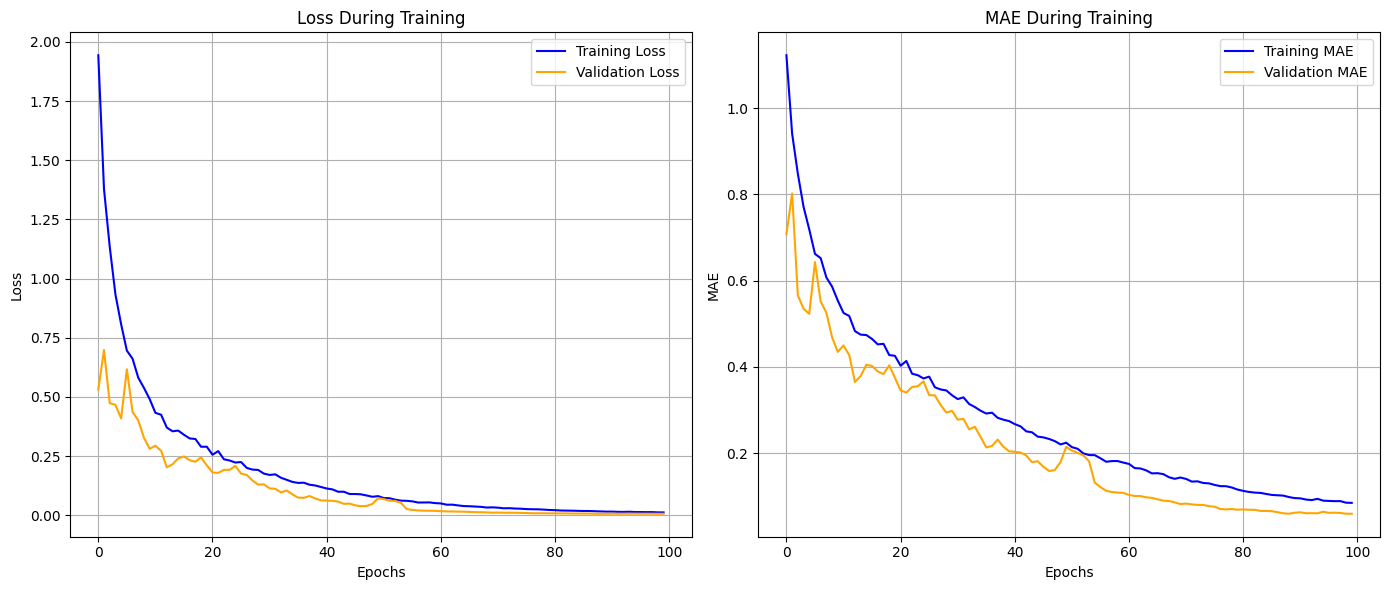

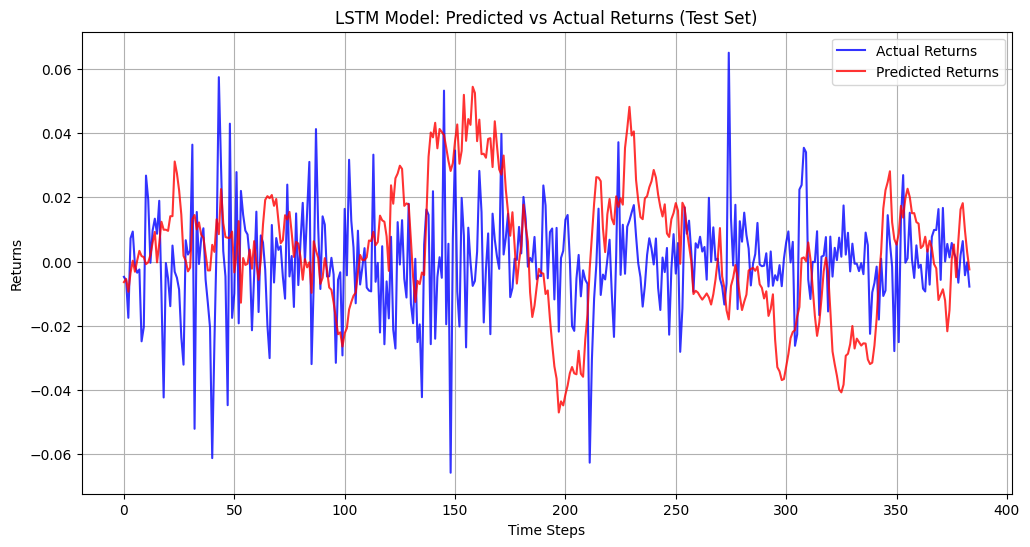

In [ ]:
error_analysis(y_test_original.flatten(), y_pred_test.flatten())
plot_training_history(history)
plot_predictions(y_test_original.flatten(), y_pred_test.flatten())

When I first started building this complex model, I did not take into considering different timestamps that different stock files have. Some of them have data started in 2000, while others have data started in 2003. That lead to large missing values and data points lost when I used dropna(). Therefore, overfitting was an issue in my first complex model. The model might learn some spurious patterns that did not generalize well. Thus, my val_loss were increasing. I then tried use some regularization and dimension reduction techniques to solve the issue and see if the model gets better. One thing weird I've noticed is that the val_loss is lower than train loss. There are several possible reasons I can think of.
- **Regularization Effects**: Techniques like Dropout, L2 regularization, or Batch Normalization are only applied during training. These mechanisms introduce noise or constraints to prevent overfitting, which may increase the training loss but not affect the validation loss.

- **Batch Normalization**: Batch Normalization computes statistics (mean and variance) differently during training and testing. During training, the mini-batch statistics might introduce variability, increasing training loss.

- **Early Stopping**: If the training process is stopped before the model fully converges, the training loss may still be decreasing, while the validation loss is already at its optimal point.

- **Small Training Batch Size**: Using a small batch size during training can introduce more noise into the gradient updates, leading to slightly higher training loss compared to the smoother validation loss.

- **Regularized Model Weights**: Training with regularized weights might result in the model being slightly under-optimized on the training data but better generalized for unseen data (validation set).

- **Training/Validation Split Bias**: If the validation set happens to be easier to predict due to randomness in the data split, it may result in a lower validation loss than training loss.

- **Dropout During Training**: Dropout increases noise by randomly deactivating neurons during training, making it harder for the model to minimize the training loss compared to validation loss where dropout is not applied.


Through my experiment, I found that the biggest issue was losing data points. Losing down to only merely over 2000 data points will not make a good model with 49 features. I revised my code above to pick stocks through limiting missing values and correlation with aapl_returns. Through that way, I can pick useful stocks and retain most of data points.

# Out of sample evaluation

*You* should test your models out of sample.

This will be beneficial as *we* will evaluate your model out of sample using a holdout data directory.

The *holdout data directory* will be for dates that are strictly later than the latest date in the
training data directory.
- will contain 2 years of data
- you will be required to predict the latest 200 returns of AAPL for this holdout directory
- your submission *must work on the holdout directory*
    - you should assume the directory is at relative path  `./data/holdout`

The holdout directory will be identical in structure and format to the training directory, just for a later date range.  No attributes will be hidden in the holdout directory.


So you might want to create your own validation/test data (from the training data directory) that mimics what the holdout data directory will contain.

It is up to you to decide on the out of sample data that you use for model development.


# Suggestions for  getting started

The problem we presented to you is unstructured and not precisely defined in full detail.

- Start by defining, in detail,  the problem that you will attempt to solve
    - Do you view this as a Regression task ?  A Classification task
    - Justify your choice
~ Define the Performance Metric that you think is appropriate
    - Justify your choice

- Start with a simple model, using only data from AAPL (few features)
    - Use the model to get a feel for the problem
    - Will be a good baseline
    - Will help you form new hypotheses to test
        - may guide the choice of additional features
- Create new models iteratively
    - Train and evaluate a "simpler" model
    - Evalute performance
    - Perform error analysis
    - Propose a new "less simple" model
        - add as many features as you like, from any file in the directory

- Be disciplined in your process: avoid repeating code
    - It will be easier if you have a single piece of code that works for
        - the training directory
        - the test directory (that you might choose to create)
        - the holdout directory
    - This will
        - simplify your process
        - help ensure that your submission will work on the holdout directory !
   

# Warning: Avoid looking into the future !

Obviously, you should not use knowledge of the future to predict future prices.

But it is surprisingly easy to inadvertantly do so !  For example:
- when standardizing a data set: you might compute averages and standard deviations over the full range of dates
    - this means that the earliest dates have implicit knowledge of later dates
        - for example, suppose the mean increases after 10 days
        - the observations of the first 9 days *should not know* that the mean of the entire data range is different than what is available from earlier observations

# Evaluating your model
   
Your goals
- demonstrate that your models can predict in-sample (based on training only) somewhat successfully
    - this is easier than predicting out of sample
    - this will show that your model has "learned" something
- evaluate your model out of sample using the validation/test set you created
- run multiple experiments to try to improve out of sample prediction
- present a "final model" which we will evaluate with a holdout dataset
     - The holdut dataset will be identical in structure to the full data set we provide
     - *BUT* the dates will be strictly after the dates in the full dataset.

# Final reminder: document your thought process

**The key to getting a good grade** is to
- document everything you do
- justify the many choices you will have to make -- use data and intuition to back up your statements
- report on failed theories/experiments
    - it shows the amount of effort you expended
    - tell us
        - why you thought it was a good idea to try
        - what you learned from the failure
        - how the failure led you to try something different
        
The out of sample prediction is hard -- you may or may not do well.

What is important is to see how you tried to improve and how failure as well as success led to
better experiments.

# Conclusion

I will choose the optimized LSTM model using only aapl data as the final model for evaluation due to the metrics and overall fitness to predict. Using only AAPL data helps ensure that the resulting model is well-calibrated to a specific market environment and can yield more accurate and interpretable predictions for the stock.

In [ ]:
print("Done")

Done
